In [33]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# Tema 1.2 $\quad$ Análisis descriptivo de los datos de un activo

Antes de analizar los datos de una cartera de activos, vamos a ver cómo se analizan los datos de un solo activo. Para ello vamos a:

* Descarga y visualización de un activo

* Comprender las limitaciones de trabajar directamente con precios

* Binomio rentabilidad-riesgo
  * Calculo de la rentabilidad diaria
  * Diferencia entre la rentabilidad aritmética y la logarítmica
  * Análisis de los retornos. ¿Siguen una distribución normal?

In [34]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
import warnings

import yfinance as yf

import statsmodels.api as sm

# print(plt.style.available) #list of available styles
plt.style.use('ggplot')

warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Descarga y visualización de un activo

Primero, descargamos los datos OHLC de Apple de los últimos 6 años para visualizarlos con diferentes herramientas.

In [35]:
data_df = yf.download('AAPL', period='6y', interval='1d')
data_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-05,43.802502,44.435001,43.630001,44.205002,41.917812,113605600
2018-03-06,44.477501,44.562500,44.032501,44.167500,41.882252,95154000
2018-03-07,43.735001,43.962502,43.567501,43.757500,41.493465,126814000
2018-03-08,43.869999,44.279999,43.767502,44.235001,41.946270,95096400
2018-03-09,44.490002,45.000000,44.347500,44.994999,42.666943,128740800


¿CUÁL ES LA DIFERENCIA ENTRE PRECIO DE CIERRE (Close) Y PRECIO DE AJUSTE (Adj Close)?

Para entender la diferencia, vamos a analizar el efecto de los splits y de los dividendos en los precios de las acciones:

* Un **split** es una división de las acciones de una empresa en varias acciones. Por ejemplo, si una acción vale 100 euros y se hace un split de 1 a 2, entonces cada acción valdrá 50 euros. El número de acciones se duplica y el precio se divide por dos.

* Un **dividendo** es un pago que hace una empresa a sus accionistas. Por ejemplo, si una acción vale 100 euros y se paga un dividendo de 5 euros, entonces el precio de la acción bajará a 95 euros.

Para ello, vamos a descargar los datos del Banco Santander de Yahoo Finance y vamso a ver los datos Close y Adj Close:

* **Close**: es el precio de cierre sin ajustar por dividendos y splits.

* **Adj Close**: es el precio de cierre ajustado por dividendos y splits. Es el precio que se utiliza para calcular las rentabilidades.

In [36]:
start_date = '2010-01-01'
end_date = '2020-12-31'

san_OHLC_df = yf.download(tickers="SAN.MC", start = start_date, end = end_date)

san_OHLC_df.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10.740401,10.916778,10.740401,10.916778,4.662075,50597478
2010-01-05,10.926061,11.093154,10.926061,11.037456,4.713610,60515839


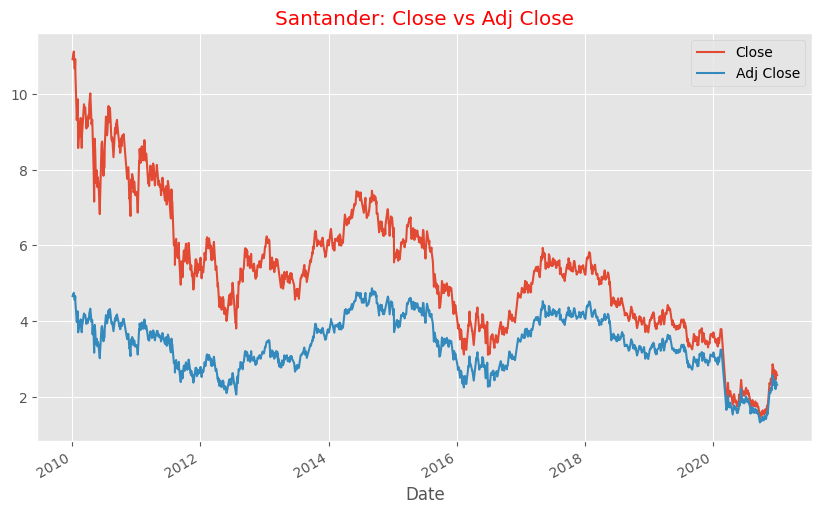

In [37]:
# Hacemos un gráfico con los precios de cierre y ajustado
san_OHLC_df[['Close', 'Adj Close']].plot(figsize=(10, 6))
plt.title('Santander: Close vs Adj Close');

También podemos bajarnos la información sobre dividendos y splits de Yahoo Finance.

In [38]:
san_OHLCDS_df = yf.download(tickers="SAN.MC", start = start_date, end = end_date, actions = True)
san_OHLCDS_df.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2010-01-04,10.740401,10.916778,10.740401,10.916778,4.662075,50597478,0.0,0.0
2010-01-05,10.926061,11.093154,10.926061,11.037456,4.713610,60515839,0.0,0.0


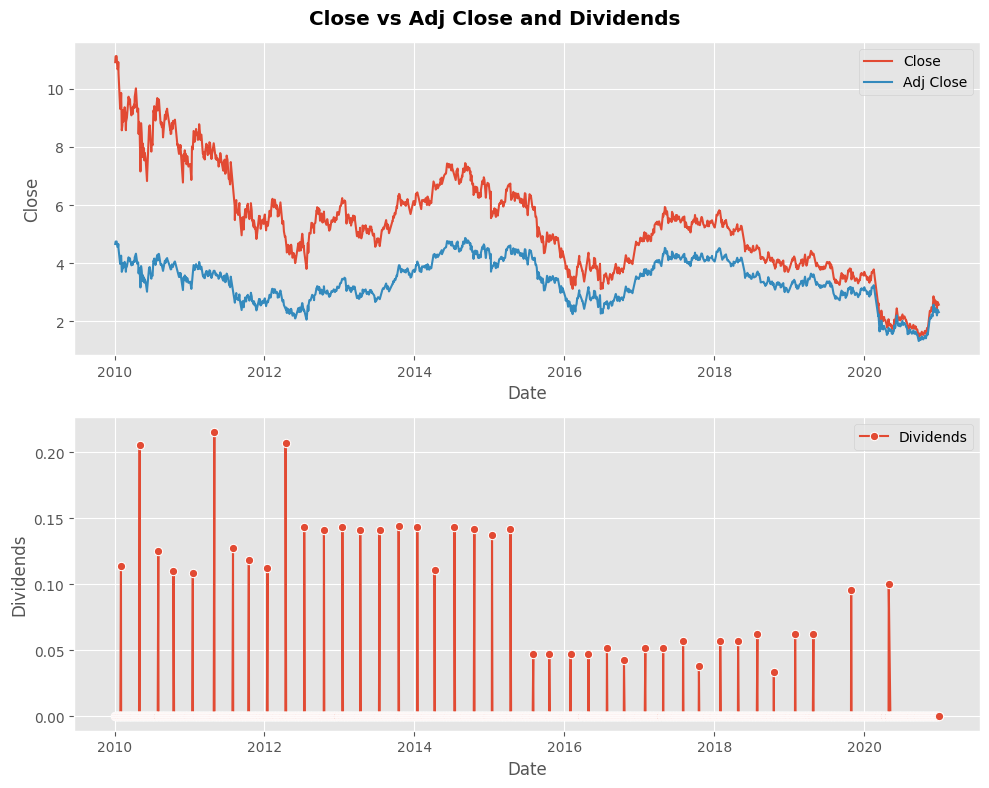

In [39]:
 # Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot "Close" and "Adj Close" on the first subplot
sns.lineplot(data=san_OHLCDS_df, x='Date', y='Close', label='Close', ax=ax1)
sns.lineplot(data=san_OHLCDS_df, x='Date', y='Adj Close', label='Adj Close', ax=ax1)

# Plot "Dividends" on the second subplot
sns.lineplot(data=san_OHLCDS_df, x='Date', y='Dividends', style=True, markers=True, dashes=False, ax=ax2)

ax2.legend(['Dividends']) 

# Adjust the layout
fig.suptitle("Close vs Adj Close and Dividends")
fig.tight_layout()

# Show the figure
plt.show()

Podemos hacer gráficos de velas usando distintas librerías:

Si utilizamos la librería `mplfinance`:

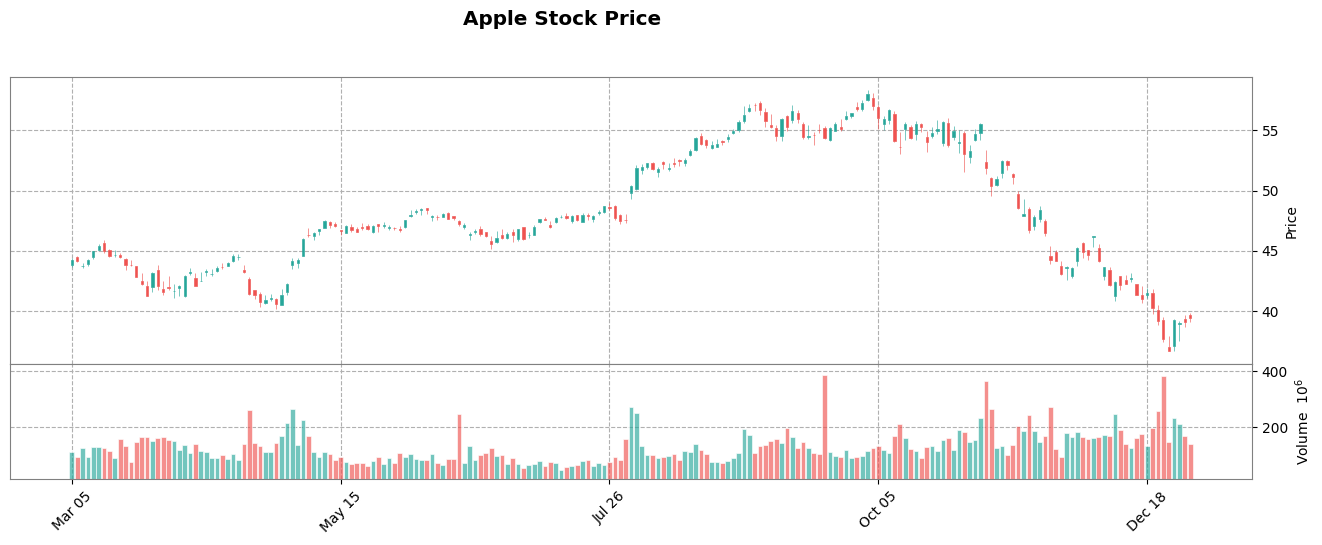

In [40]:
company='Apple'
mpf.plot(data_df.loc["2018"], 
         type='candle', # En el argumento type indicamos que queremos dibujar un gráfico de velas
         volume=True, # El argumento volume indica si queremos representar el volumen
         style='tradingview', # El argumento style nos permite visualizar los datos como en la plataforma TradingView
         figratio=(12, 4),
         title=f'{company} Stock Price')

Si utilizamos la librería `plotly`:

In [41]:
fig = go.Figure(data=[go.Candlestick(x=data_df.loc["2018"].index,
                                     open=data_df.loc["2018"]['Open'],
                                     high=data_df.loc["2018"]['High'],
                                     low=data_df.loc["2018"]['Low'],
                                     close=data_df.loc["2018"]['Close'])
                     ])

fig.update_layout(title = f'{company}: Candlestick Price Chart', xaxis_tickfont_size = 14)
fig.update_layout(xaxis_rangeslider_visible = False)
    
fig.show()

Prueba a pasar el ratón por encima de la figura en una vela en concreto. Puedes ver la información detallada de ese día. También puedes hacer zoom, desplazar la figura, etc.

## 1.2 Precios vs Retornos

En el ámbito financiero, no suele ser común trabajar directamente con los precios de los activos, sino que trabajamos con los **retornos** de los precios. Existen dos formas de calcular los retornos a partir de los precios de un activo:

**Retornos aritméticos:**

$$r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

donde $P_t$ y $P_{t-1}$ representan los precios de cierre en los instantes de tiempo $t$ y $t-1$, respectivamente.

**Retornos logarítmicos:**

$$r_t = ln(\frac{P_t}{P_{t-1}}) = ln(P_t) - ln(P_{t-1})$$

donde, como antes, $P_t$ y $P_{t-1}$ representan los precios de cierre en los instantes de tiempo $t$ y $t-1$, respectivamente.

En ambas situaciones, estamos calculando de cierta manera la diferencia de los precios en dos instantes de tiempo consecutivos $t$ y $t-1$. Imagina que estás hablando sobre el crecimiento de una planta en tu jardín. En lugar de mirar la altura absoluta de la planta cada día, podrías estar más interesado en apuntar cuánto ha crecido en comparación con el día anterior. Este enfoque te permite medir el crecimiento de manera más consistente y comparar fácilmente el desarrollo de diferentes plantas, incluso si algunas son más grandes que otras desde el principio.

De manera similar, en finanzas trabajamos con retornos porque nos centramos en **cómo los activos cambian** en comparación con su valor anterior, en lugar de mirar directamente el precio absoluto. Al hacerlo, podemos comparar diferentes activos y entender mejor cómo varían, lo que facilita la toma de decisiones y el análisis sin verse afectados por las diferencias en la escala de los precios. Es como medir el crecimiento de las plantas observando cuánto han crecido en lugar de simplemente mirar su altura total.

Además, hay una serie de razones por las que es más ventajoso trabajar con retornos:

- **Normalización de datos**: Los retornos permiten normalizar los datos y eliminar la escala absoluta de los precios. Esto facilita la comparación entre diferentes activos financieros, especialmente aquellos con precios muy diferentes.

- **Facilita el análisis estadístico**: Al trabajar con retornos, se asume que las **rentabilidades son estacionarias débiles** y tienen propiedades estadísticas más estables que los precios absolutos. Esto facilita el uso de herramientas estadísticas y modelos matemáticos en el análisis financiero.

- **Gestión de riesgos**: En el ámbito de la gestión de riesgos, los retornos son cruciales. Los inversores y gestores de fondos suelen evaluar el riesgo en términos de variaciones en los retornos más que en los cambios absolutos en los precios.

- **Elimina tendencias a largo plazo**: Al trabajar con retornos, se tiende a eliminar las tendencias a largo plazo en los datos, centrándose más en las fluctuaciones diarias o periódicas.

- **Simplicidad en cálculos**: En muchos casos, los cálculos de retornos son más simples que los de precios, especialmente cuando se trata de comparar activos a lo largo del tiempo.

Veamos la diferencia entre calcular los retornos aritméticos y logarítmicos:

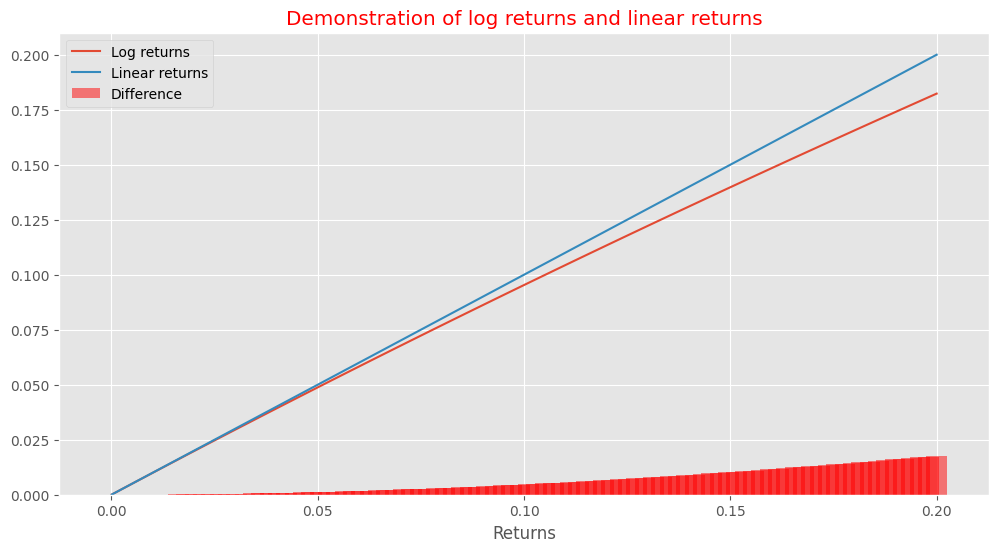

In [42]:
plt.style.use('ggplot')
x_returns = np.linspace(0.0001, .2, 100) # Generate 100 numbers between 0.0001 and 0.2
y_returns = np.log(1 + x_returns) # Calculate the logarithmic returns from the linear returns

# Plot the linear and log returns
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x_returns, y_returns, label='Log returns') # Plot the log returns
plt.plot(x_returns, x_returns, label='Linear returns') # Plot the linear returns
plt.bar(x_returns, x_returns-y_returns, width=0.005, color='r', alpha=0.5, label='Difference', ) # Plot the difference between the two returns
plt.legend()
plt.xlabel('Returns')
plt.title('Demonstration of log returns and linear returns');

Volvemos al dataset anterior con los precios de Apple en los últimos 6 años. Vamos a calcular los retornos aritméticos y logarítmicos:

In [43]:
# Retornos aritméticos
ret_arit = data_df["Adj Close"].pct_change()
ret_arit

Date
2018-03-05         NaN
2018-03-06   -0.000848
2018-03-07   -0.009283
2018-03-08    0.010913
2018-03-09    0.017181
                ...   
2024-02-28   -0.006625
2024-02-29   -0.003693
2024-03-01   -0.006030
2024-03-04   -0.025381
2024-03-05   -0.028469
Name: Adj Close, Length: 1511, dtype: float64

In [44]:
# Retornos logarítmicos
ret_log = np.log(data_df["Adj Close"]).diff()
ret_log

Date
2018-03-05         NaN
2018-03-06   -0.000849
2018-03-07   -0.009326
2018-03-08    0.010854
2018-03-09    0.017035
                ...   
2024-02-28   -0.006647
2024-02-29   -0.003700
2024-03-01   -0.006049
2024-03-04   -0.025709
2024-03-05   -0.028883
Name: Adj Close, Length: 1511, dtype: float64

Como véis, son prácticamente iguales. Por tanto, por comodidad en el resto de operaciones, **vamos a trabajar con retornos logarítmicos**.

In [45]:
ret_df = ret_log.dropna()

## 1.3 Binomio rentabilidad-riesgo

Pintemos los retornos para ver su evolución temporal:

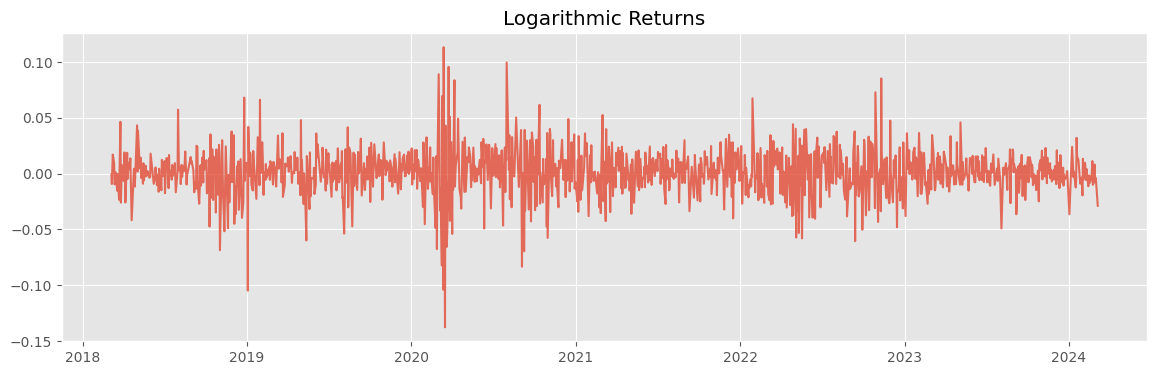

In [93]:
plt.figure(figsize=(14, 4))
plt.plot(ret_df, alpha=0.8)
plt.title('Logarithmic Returns', c='black')
plt.show()

Veamos ahora su distribución:

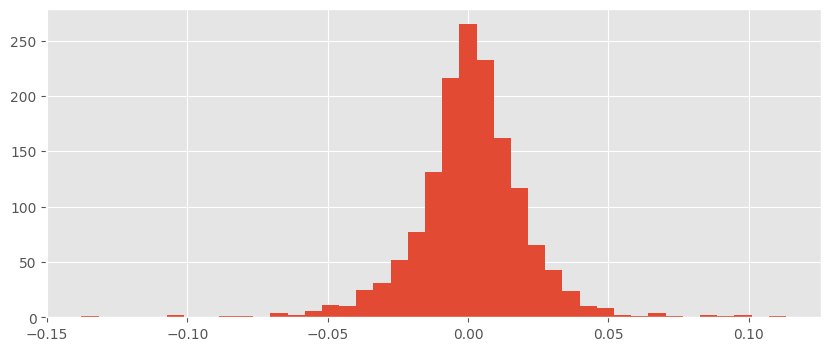

In [47]:
plt.figure(figsize=(10, 4))
plt.hist(ret_df, bins=41)
plt.show()

Viendo la figura, aparentemente sigue una distribución Normal (Gaussiana). Entonces, podemos caracterizar los datos mediante su media y su desviación estándar:

1. Se calcula la rentabilidad media de los retornos:

$$\bar{r} = \frac{1}{n} \sum_{i=1}^n r_i$$

2. Se calcula la varianza de los retornos:

$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (r_i - \bar{r})^2$$

3. Se calcula la desviación típica de los retornos:

$$\sigma = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (r_i - \bar{r})^2}$$

La rentabilidad, varianza y desviación típica **siempre se expresa en términos anuales**:

- Si los datos son diarios, consideramos que hay 252 días al año de negociación.
- Si los datos son mensuales, consideramos que hay 12 meses al año.

In [48]:
print(" Rentabilidad media: {:.4f}".format(ret_df.mean()*252))
print(" Varianza: {:.4f}".format(ret_df.var()*252))
print(" Desviación estándar: {:.4f}".format(np.sqrt(252)*ret_df.std()))

 Rentabilidad media: 0.2338
 Varianza: 0.0996
 Desviación estándar: 0.3157


Dado que los inversores tienen aversión al riesgo, los activos los representamos por el **binomio rentabilidad-riesgo**:

- La **rentabilidad** se mide como la media de los retornos.
    
- El **riesgo** se mide a través de la volatilidad, que es la desviación estándar de los rendimientos.

---

Vamos a descargar dos grupos de activos que nos servirán para analizar distintos comportamientos.

Lectura de los ficheros desde Github (utilizar desde colab)

In [49]:
file_path = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_1_Activos_Intro/data/data_OHLC.xlsx'
data_OHLC_df = pd.read_excel(file_path, header=[0, 1], index_col=0, parse_dates=True)

file_path = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_1_Activos_Intro/data/data_OHLC_corr.xlsx'
data_OHLC_df_corr = pd.read_excel(file_path, header=[0, 1], index_col=0, parse_dates=True)

Lectura de los ficheros en local

In [50]:
data_OHLC_df = pd.read_excel('../data/data_OHLC.xlsx', header=[0, 1], index_col=0, parse_dates=True)
data_OHLC_df_corr = pd.read_excel('../data/data_OHLC_corr.xlsx', header=[0, 1], index_col=0, parse_dates=True)

In [51]:
data_OHLC_df.head()

Adj Close                                                     \
                 AAPL BTC-USD    ELE.MC        IAU        IEF       TSLA   
Date                                                                       
2013-10-07  15.203007     NaN  5.184735  25.680000  84.856277  12.204667   
2013-10-08  14.990746     NaN  5.180736  25.620001  84.814644  11.648667   
2013-10-09  15.166854     NaN  5.262038  25.340000  84.664726  11.252000   
2013-10-10  15.261921     NaN  5.336677  24.980000  84.481369  11.528667   
2013-10-11  15.360727     NaN  5.343342  24.639999  84.606331  11.913333   

                Close                                ...       Open  \
                 AAPL BTC-USD     ELE.MC        IAU  ...     ELE.MC   
Date                                                 ...              
2013-10-07  17.419643     NaN  19.450001  25.680000  ...  19.360001   
2013-10-08  17.176430     NaN  19.434999  25.620001  ...  19.420000   
2013-10-09  17.378214     NaN  19.740000  25.340000  ...  19.375000   
2013-10-10  17.487143     NaN  20.020000  24.980000  ...  19.825001   
2013-10-11  17.600357     NaN  20.045000  24.639999  ...  20.045000   

                                                   Volume                    \
                  IAU         IEF       TSLA         AAPL BTC-USD    ELE.MC   
Date                                                                          
2013-10-07  25.580000  102.059998  12.164000  312292400.0     NaN  121645.0   
2013-10-08  25.719999  101.800003  12.293333  290917200.0     NaN  143155.0   
2013-10-09  25.379999  101.790001  11.648667  301725200.0     NaN  268379.0   
2013-10-10  25.200001  101.269997  11.539333  278602800.0     NaN  340366.0   
2013-10-11  24.620001  101.690002  11.516667  267738800.0     NaN  173073.0   

                                              
                  IAU       IEF         TSLA  
Date                                          
2013-10-07  2414350.0  454400.0  172284000.0  
2013-10-08  1434200.0  818100.0  206358000.0  
2013-10-09  3605650.0  506500.0  229747500.0  
2013-10-10  3883650.0  649100.0  133258500.0  
2013-10-11  2674950.0  850100.0  124666500.0  

[5 rows x 36 columns]

Nos quedamos con los datos de cierre de cada día y calculamos los rendimientos diarios.

In [52]:
data_close_df = data_OHLC_df['Adj Close'].dropna()
ret_close_df = np.log(data_close_df).diff().dropna()

In [53]:
data_OHLC_df_corr.head()

Adj Close                                                          \
                 AAPL       CSCO         IBM       INTC       MSFT       ORCL   
Date                                                                            
2013-10-07  15.203010  16.748629  115.038887  17.101440  27.885912  28.221779   
2013-10-08  14.990749  16.565710  112.959435  16.839266  27.643059  27.817881   
2013-10-09  15.166852  16.463264  114.602745  16.921661  27.693300  27.663189   
2013-10-10  15.261921  16.836430  116.783310  17.303694  28.271114  28.350683   
2013-10-11  15.360729  17.033991  117.661797  17.423548  28.580963  28.582718   

                Close                                ...        Open  \
                 AAPL       CSCO         IBM   INTC  ...         IBM   
Date                                                 ...               
2013-10-07  17.419643  22.889999  174.005737  22.83  ...  173.852768   
2013-10-08  17.176430  22.639999  170.860428  22.48  ...  173.891006   
2013-10-09  17.378214  22.500000  173.346085  22.59  ...  171.481842   
2013-10-10  17.487143  23.010000  176.644363  23.10  ...  175.114716   
2013-10-11  17.600357  23.280001  177.973236  23.26  ...  177.103256   

                                                Volume                     \
                 INTC       MSFT       ORCL       AAPL      CSCO      IBM   
Date                                                                        
2013-10-07  22.709999  33.599998  32.860001  312292400  29575900  4148854   
2013-10-08  22.870001  33.310001  32.830002  290917200  31865700  5834902   
2013-10-09  22.510000  33.070000  32.450001  301725200  45438300  4626981   
2013-10-10  22.990000  33.310001  32.480000  278602800  38817500  3827209   
2013-10-11  22.830000  33.680000  33.080002  267738800  27773800  3381300   

                                          
                INTC      MSFT      ORCL  
Date                                      
2013-10-07  21321300  35069300  14150100  
2013-10-08  36111200  41017600  23780400  
2013-10-09  40435400  35878600  19656000  
2013-10-10  39189400  42875100  21580700  
2013-10-11  24550600  30033300  14018800  

[5 rows x 36 columns]

Nos quedamos con los datos de cierre de cada día y calculamos los rendimientos diarios.

In [54]:
data_close_df_corr = data_OHLC_df_corr['Adj Close'].dropna()
ret_close_df_corr = np.log(data_close_df_corr).diff().dropna()

Hacemos unas gráficas para ver la rentabilidad y volatilidad de cada activo.

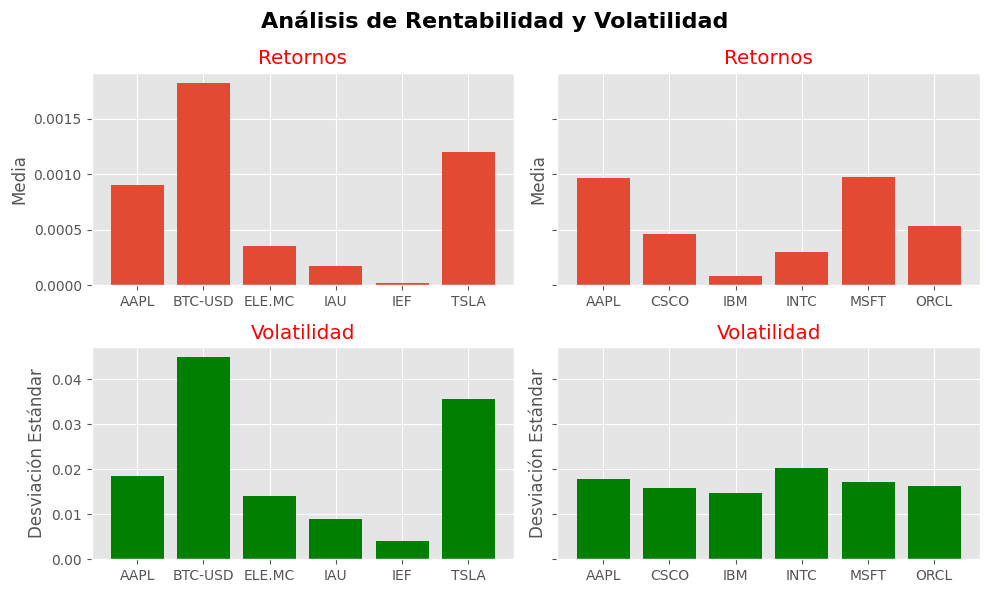

In [55]:
# Puedes calcular los valores medios y la desviación estándar de cada columna así:
means = ret_close_df.mean()
stds = ret_close_df.std()
means_corr = ret_close_df_corr.mean()
stds_corr = ret_close_df_corr.std()

# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0, 0].bar(means.index, means.values)
axes[0, 0].set_ylabel('Media')
axes[0, 0].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 0].bar(stds.index, stds.values,color='green')
axes[1, 0].set_ylabel('Desviación Estándar')
axes[1, 0].set_title('Volatilidad')

#Crear una figura con dos subplots, uno encima del otro
axes[0, 1].bar(means_corr.index, means_corr.values)
axes[0, 1].set_ylabel('Media')
axes[0, 1].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 1].bar(stds_corr.index, stds_corr.values,color='green')
axes[1, 1].set_ylabel('Desviación Estándar')
axes[1, 1].set_title('Volatilidad')

# Añadir un título general a la figura
plt.suptitle('Análisis de Rentabilidad y Volatilidad', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Vamos a comparar los retornos de dos activos. Concretamente `Bitcoin` (BTC-USD) frente a los `Bonos US` (IEF).

In [56]:
# Crear un gráfico de líneas con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=ret_close_df.loc['2016-05-01':,  :].index, 
                         y=ret_close_df.loc['2016-05-01':,  :]['BTC-USD'], 
                         mode='lines',
                         name='BTC-USD'))

fig.add_trace(go.Scatter(x=ret_close_df.loc['2016-05-01':,  :].index, 
                         y=ret_close_df.loc['2016-05-01':,  :]['IEF'], 
                         mode='lines',
                         name='IEF')) #iShares 7-10 Year Treasury Bond ETF

# Añadir títulos
fig.update_layout(
    title="COMPARACIÓN ACTIVOS CON MUCHA Y POCA VOLATILIDAD",
    title_font=dict(size=18),  # Ajusta el tamaño del título
    title_x=0.5,  # Centra el título
    yaxis_title="Retornos diarios %",
    margin=dict(l=20, r=20, b=20, t=40),  # Ajusta los márgenes para hacer los bordes más pequeños
)

También podemos verlo usando las gráficas de distribución de los retornos diarios de cada activo:

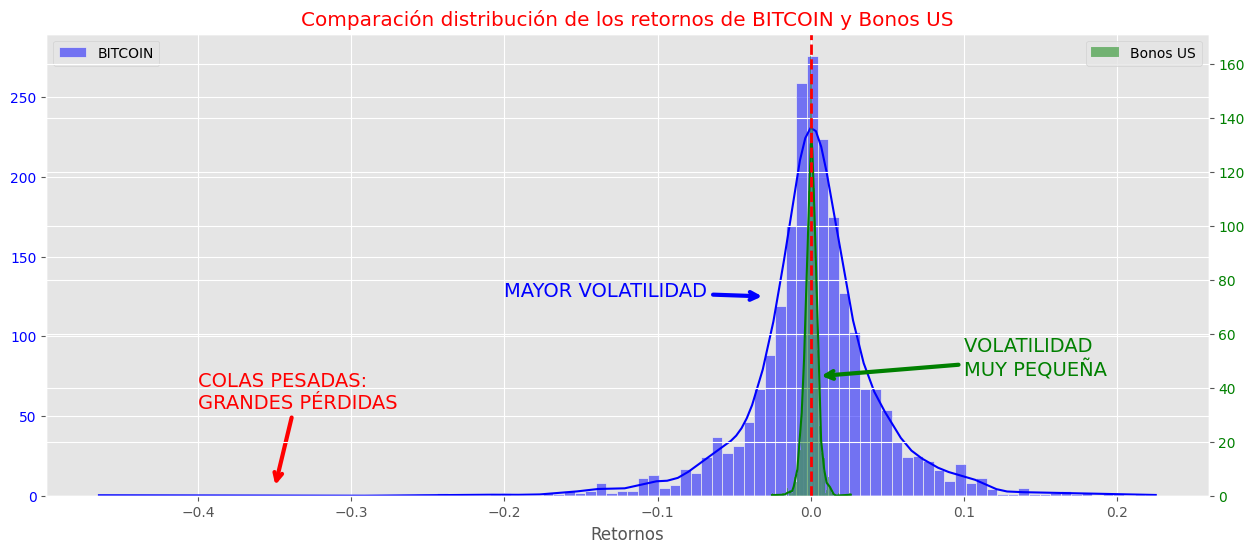

In [57]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Crear el primer gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='BTC-USD', ax=ax1, bins=100, color='blue', kde=True, alpha=0.5, label='BITCOIN')
ax1.set_xlabel('Retornos')
ax1.set_ylabel('', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# # Añadir texto en ax2
# text_x = -0.4
# text_y = 25

#ax1.text(-0.2, 125, f"MAYOR VOLATILIDAD", fontsize=12, color='blue')

ax1.annotate('MAYOR VOLATILIDAD', xy=(-0.03, 125), xytext=(-0.2, 125),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='blue'),
            fontsize=14, color='blue')

ax1.annotate('VOLATILIDAD \nMUY PEQUEÑA', xy=(0.005, 75), xytext=(0.1, 75),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

ax1.annotate('COLAS PESADAS: \nGRANDES PÉRDIDAS', xy=(-0.35, 5), xytext=(-0.4, 55),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')



# Duplicar el eje Y para el segundo gráfico
ax2 = ax1.twinx()

# Crear el segundo gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=100, color='green', kde=True, alpha=0.5, label='Bonos US')
ax2.set_ylabel('', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Añadir una línea vertical en el eje X en 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
# Configurar título y mostrar el gráfico
plt.title('Comparación distribución de los retornos de BITCOIN y Bonos US')
plt.show()

In [58]:
print("BITCOIN:")
print("  MEDIA:", np.around(ret_close_df['BTC-USD'].mean() * 252, decimals=3))
print("  STD:", np.around(ret_close_df['BTC-USD'].std() * np.sqrt(252), decimals=3))
print()
print("BONOS:")
print("  MEDIA:", np.around(ret_close_df['IEF'].mean() * 252, decimals=3))
print("  STD:", np.around(ret_close_df['IEF'].std() * np.sqrt(252), decimals=3))

BITCOIN:
  MEDIA: 0.459
  STD: 0.713

BONOS:
  MEDIA: 0.004
  STD: 0.066


---

#### Ejercicio

Descarga los datos del fichero `../data/datos_ejercicio_asimetria.csv` y realiza los siguientes apartados con los dos activos que te damos: 

1. Haz una gráfica para visualizar los retornos de cada activo. ¿Qué observas?

2. Analiza el binomio media-varianza. ¿En cuál es más interesante invertir?

Lectura de los ficheros desde Github (utilizar desde colab)

In [59]:
file_path = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_1_Activos_Intro/data/datos_ejercicio_asimetria.csv'
datos_activo = pd.read_csv(file_path, index_col=0, parse_dates=True)
datos_activo

,Activo,BTC-USD
Date,,
2014-09-18,-0.023950,-0.074643
2014-09-19,0.003392,-0.072402
2014-09-22,0.028220,0.018461
2014-09-23,0.043569,0.080333
2014-09-24,0.016959,-0.029306
...,...,...
2023-09-28,-0.037223,0.025063
2023-09-29,-0.056761,-0.004073
2023-10-02,-0.071284,0.022743


Lectura fichero local

In [60]:
datos_activo = pd.read_csv("../data/datos_ejercicio_asimetria.csv", index_col=0, parse_dates=True)
datos_activo

,Activo,BTC-USD
Date,,
2014-09-18,-0.023950,-0.074643
2014-09-19,0.003392,-0.072402
2014-09-22,0.028220,0.018461
2014-09-23,0.043569,0.080333
2014-09-24,0.016959,-0.029306
...,...,...
2023-09-28,-0.037223,0.025063
2023-09-29,-0.056761,-0.004073
2023-10-02,-0.071284,0.022743


In [61]:
# TO-DO: Incluye aquí tus cálculos y explicaciones


---

Para poder analizar el comportamiento de un activo necesitamos la distribución de los retornos, pero en general se emplea solo la rentabilidad y el riesgo.

La teoría de que los activos se pueden caracterizar por el binomio rentabilidad-riesgo se cumple si:

* La función de utilidad del inversor es cuadrática. Fuera del scope de este curso.

* Los **retornos siguen una distribución normal**: Una normal se caracteriza por media y varianza.  

Vamos a comprobar si esta vez los retornos siguen una normal. Para comprobarlo, vamos a usar los retornos de `Bitcoin` y los vamos a comparar con una distribución normal con la misma media y desviación estándar. Para ello, generamos unos datos sintéticos con distribución normal, media y desviación igual a la de los retornos de Bitcoin.

In [83]:
# Definir la media y la desviación estándar
media = ret_close_df['BTC-USD'].mean()
std = ret_close_df['BTC-USD'].std()

# Establecer la semilla (seed)
np.random.seed(3)  # Puedes usar cualquier número como semilla

# Generar una serie de números con distribución normal
data_norm = np.random.normal(media, std, 100000)  # 100000 números aleatorios

Usaremos los gráficos QQ-Plot para visualizar la distribución de los datos. Si los puntos se ajustan a la recta, los datos siguen una distribución normal.

Para más información sobre QQ-Plot pinchar [aquí](https://es.wikipedia.org/wiki/Gr%C3%A1fico_Q-Q)

<img src="../imgs/qinq.PNG" alt="QinQ e histogramas" style="max-width:70%">

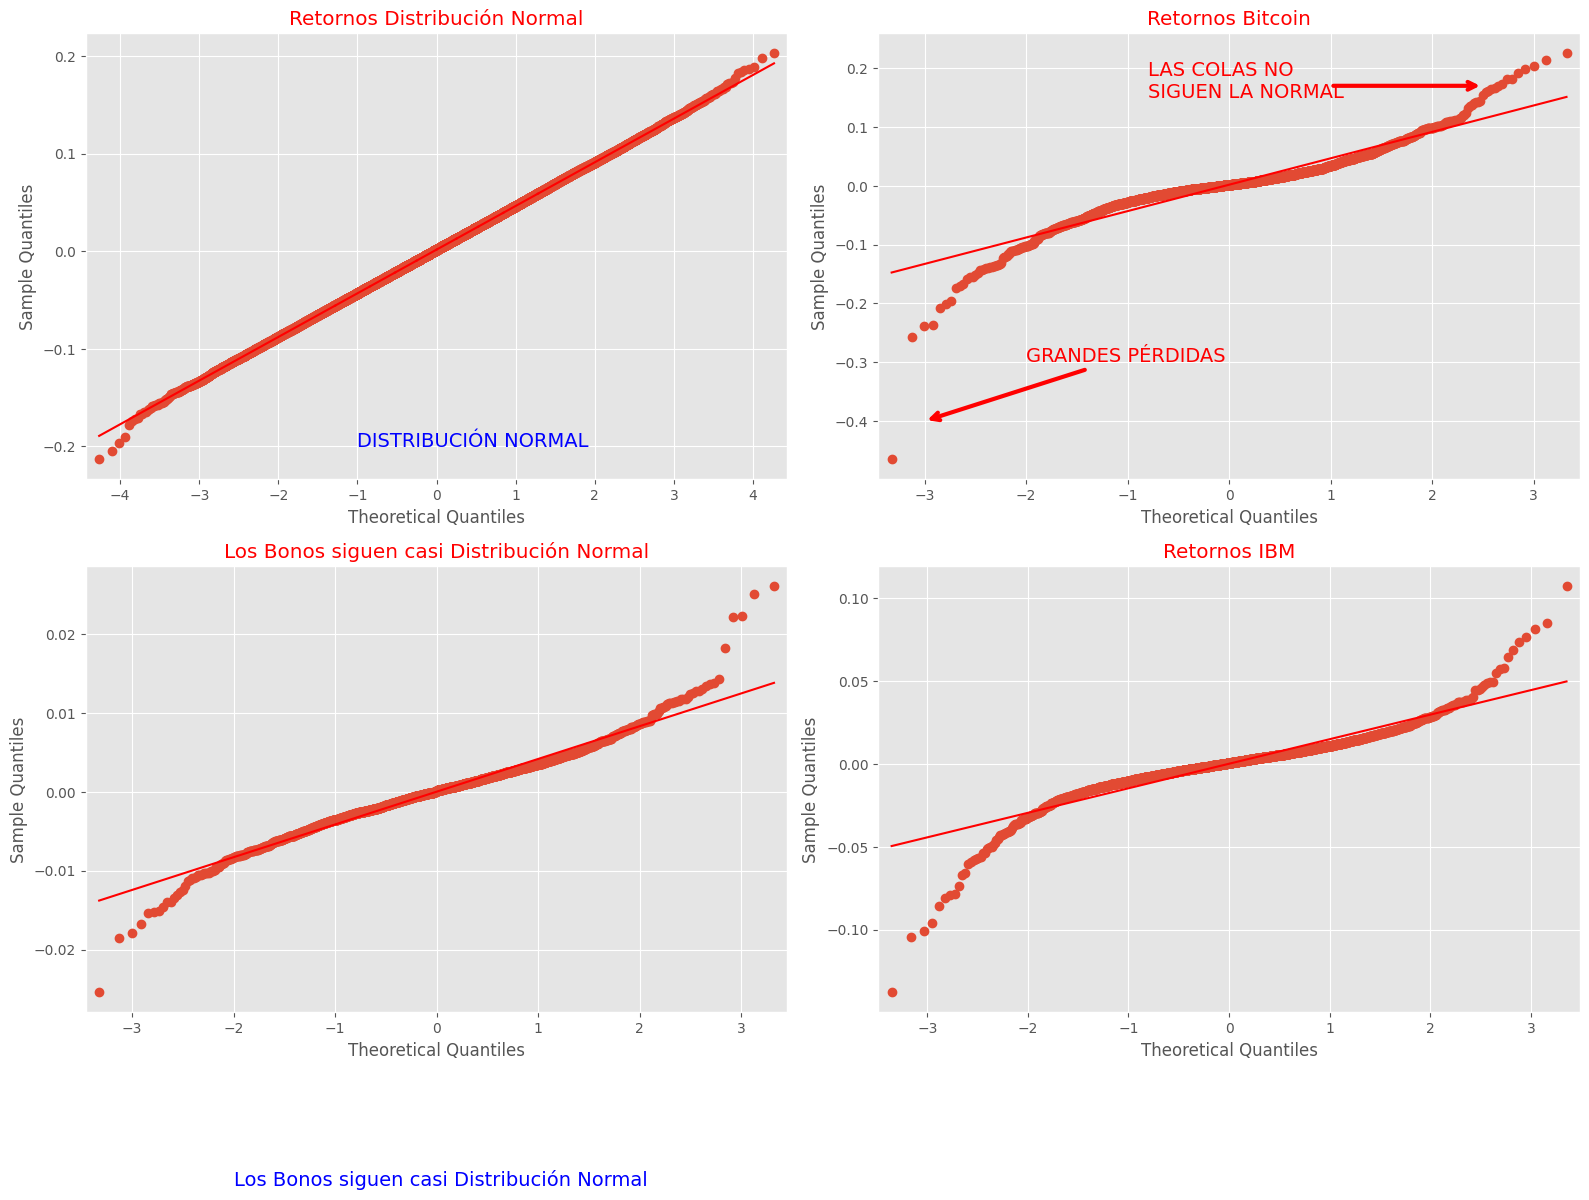

In [89]:
# Crear una figura con dos subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))#, sharey='row')

# Graficar el primer histograma en el primer subplot
sm.qqplot(data_norm, line='s', ax=axs[0,0])
axs[0,0].set_title('Retornos Distribución Normal')

axs[0,0].text(-1, -0.2, "DISTRIBUCIÓN NORMAL", fontsize=14, color='blue')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['BTC-USD'], line='s', ax=axs[0,1])
axs[0,1].set_title('Retornos Bitcoin')

# Añadir texto en ax2
text_x = -3
text_y = -0.35

#axs[0,1].text(text_x, text_y, "GRANDES PÉRDIDAS", fontsize=14, color='RED')

text_x = -1.5
text_y = 0.15

axs[0,1].text(-0.8, 0.15, "LAS COLAS NO \nSIGUEN LA NORMAL", fontsize=14, color='RED')

axs[0,1].annotate("", xy=(2.5, 0.17), xytext=(1, 0.17),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')


# Dibuja una flecha utilizando annotate
axs[0,1].annotate('GRANDES PÉRDIDAS', xy=(-3, -0.4), xytext=(-2, -0.3),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')


# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['IEF'], line='s', ax=axs[1,0])
axs[1,0].set_title('Retornos Bonos US')
axs[1,0].set_title('Los Bonos siguen casi Distribución Normal')
axs[1,0].text(-2, -0.05, "Los Bonos siguen casi Distribución Normal", fontsize=14, color='blue')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df_corr['IBM'], line='s', ax=axs[1,1])
axs[1,1].set_title('Retornos IBM')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

Vamos a aplicar el test de [Kolmogorov-Smirnov](https://es.wikipedia.org/wiki/Prueba_de_Kolmog%C3%B3rov-Smirnov) para comprobar si Bitcoin sigue una distribución normal.

In [64]:
# Prueba de Kolmogorov-Smirnov
stat, p = stats.kstest(ret_close_df['BTC-USD'], 'norm')

# Compara el valor p con un nivel de significancia (por ejemplo, 0.05)
alpha = 0.05
if p > alpha:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos SÍ SIGUEN una distribución normal (no podemos rechazar la hipótesis nula)")
else:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)")

El resultado es de 0.0000, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)


Existen otros tests como el test Anderson-Darling. La prueba de Anderson-Darling es especialmente útil porque es más sensible a las colas de la distribución en comparación con otras pruebas, como la prueba de Kolmogorov-Smirnov.

Para ver cómo se realiza este test ver [Anderson-Darling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)

Hemos podido comprobar que los retornos **no siempre siguen una distribución normal**. Concretamente, hemos visto que las colas de la distribución de los retornos son más pesadas que las de una distribución normal. Esto quiere decir que hay más probabilidad de que ocurran eventos extremos (tanto positivos como negativos) de lo que cabría esperar si los retornos siguieran una distribución normal.

Necesitamos más estadísticos para describir un activo. Por tanto vamos a estimar la asimetría y la curtosis de la función de distribución de los retornos y, por otro lado, plantearemos caracterizar los activos utilizando otras funciones de probabilidad, como la t-student.


## 1.4 Asimetría y Curtosis

### Asimetría o skewness

El tercer momento de una función de distribución nos mide su nivel de asimetría. Así:

* Una asimetría positiva indica que la acción tiene una mayor probabilidad por encima de la media.

* Una asimetría negativa indica que la acción tiene una mayor probabilidad por debajo de la media.

* Una asimetría neutra indica que la acción tiene una probabilidad equilibrada a ambos lados de la media.

<center>
    <img src="../imgs/skewness.PNG"  alt="drawing" width="500">
</center>

Analicemos la asimetría de los retornos de los activos que tenemos. Si los retornos siguieran una distribución normal, la asimetría debería ser 0.

In [65]:
df_skew = ret_close_df.skew()
df_corr_skew = ret_close_df_corr.skew()

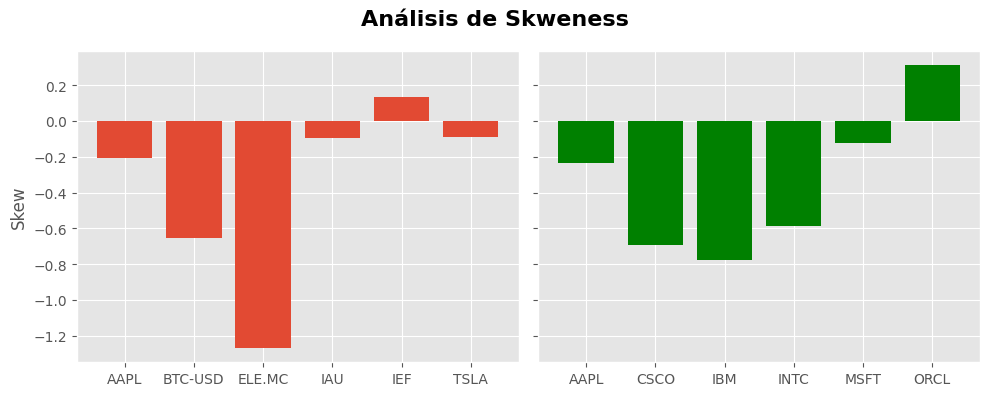

In [66]:
# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0].bar(df_skew.index.values, df_skew.values)
axes[0].set_ylabel('Skew')
axes[0].set_title('')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1].bar(df_corr_skew.index.values, df_corr_skew.values ,color='green')
axes[1].set_ylabel('')
axes[1].set_title('')


# Añadir un título general a la figura
plt.suptitle('Análisis de Skweness', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Podemos observar que, mayoritariamente, predominan los activos con asimetrías negativas. Eso significa que, por lo general, la cola izquierda es más pesada que la derecha. Es decir, hay más probabilidad de que ocurran eventos negativos extremos que positivos extremos.

Veamos qué sucede con `Endesa` (ELE.MC), que tiene una asimetría negativa elevada:

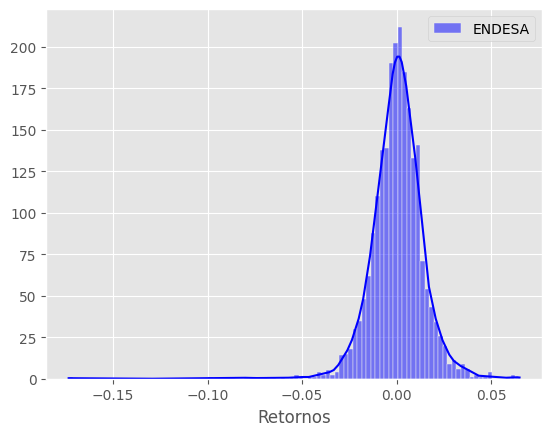

In [67]:
sns.histplot(data=ret_close_df, x='ELE.MC', bins=100, color='blue', kde=True, alpha=0.5, label='ENDESA')
plt.xlabel('Retornos')
plt.ylabel('', color='blue')
plt.legend()
plt.show()

In [68]:
print("Asimetría de Endesa:", np.around(ret_close_df["ELE.MC"].skew(), decimals=3))

Asimetría de Endesa: -1.27


Veamos qué sucede con `Oracle` (ORCL), que tiene una asimetría postiva elevada:

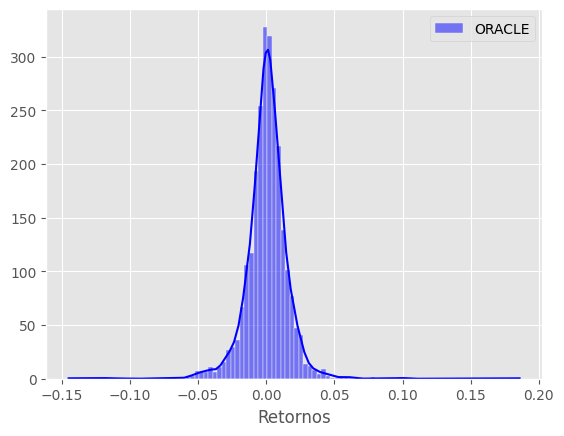

In [69]:
sns.histplot(data=ret_close_df_corr, x='ORCL', bins=100, color='blue', kde=True, alpha=0.5, label='ORACLE')
plt.xlabel('Retornos')
plt.ylabel('', color='blue')
plt.legend()
plt.show()

In [70]:
print("Asimetría de Oracle:", np.around(ret_close_df_corr["ORCL"].skew(), decimals=3))

Asimetría de Oracle: 0.312


Veamos qué sucede con `Tesla` (TSLA), que tiene una asimetría neutra:

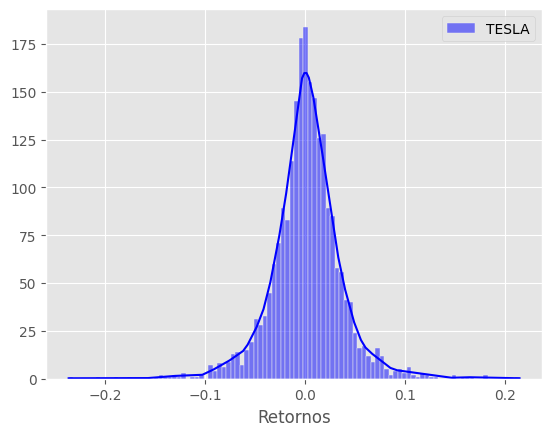

In [71]:
sns.histplot(data=ret_close_df, x='TSLA', bins=100, color='blue', kde=True, alpha=0.5, label='TESLA')
plt.xlabel('Retornos')
plt.ylabel('', color='blue')
plt.legend()
plt.show()

In [72]:
print("Asimetría de Tesla:", np.around(ret_close_df["TSLA"].skew(), decimals=3))

Asimetría de Tesla: -0.087


<hr>

### Curtosis o kurtosis

La curtosis, en estadística, es una medida que describe la forma de la distribución de los datos, específicamente cuán "pesadas" o "ligeras" son las colas de la distribución en comparación con una distribución normal (campana de Gauss). Aquí te ofrezco una forma intuitiva de explicarla:
 
Imagina que tienes dos montañas hechas de arena. La primera montaña es amplia y baja, extendiéndose suavemente hacia los lados. La segunda montaña es más alta y puntiaguda, con lados más empinados. Ambas montañas pueden tener la misma cantidad de arena, pero están distribuidas de manera diferente.
 
- **Curtosis baja (Platicúrtica)**: Es como la primera montaña, más plana y extendida. Esto significa que los datos están más dispersos, hay menos concentración de datos cerca del promedio y las colas son más "ligeras". En esta distribución, los eventos extremos (muy lejos del promedio) son menos comunes.
 
- **Curtosis alta (Leptocúrtica)**: Es como la segunda montaña, más alta y estrecha. Aquí, los datos están más concentrados cerca del promedio y las colas son más "pesadas". Esto implica que hay una mayor probabilidad de encontrar valores extremos.
 
- **Curtosis normal (Mesocúrtica)**: Es similar a la distribución normal, ni muy plana ni muy puntiaguda. Representa un equilibrio entre la dispersión de los datos y la frecuencia de eventos extremos.
 
En resumen, la curtosis te dice si los eventos extremos son más o menos comunes en tu conjunto de datos en comparación con una distribución normal. Es importante recordar que la curtosis no mide los picos en sí, sino la "pesadez" de las colas de la distribución.

La interpretación de la curtosis de los retornos de una acción es la siguiente:

* Una curtosis **igual a 0** indica que os retornos siguen una **distribución normal**.

* Una curtosis **mayor que 0** indica que la acción tiene una **mayor probabilidad de generar retornos extremos**, ya sean positivos o negativos.

* Una curtosis **menor que 0** indica que la acción tiene una **menor probabilidad de generar retornos extremos**.

In [73]:
df_curto = ret_close_df.kurtosis()
df_corr_curto = ret_close_df_corr.kurtosis()

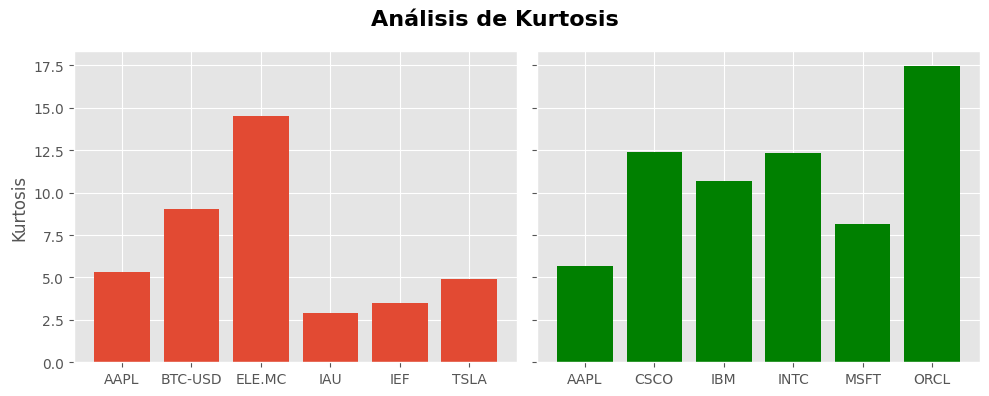

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='row')
axes[0].bar(df_curto.index.values, df_curto.values)
axes[0].set_ylabel('Kurtosis')
axes[0].set_title('')
axes[1].bar(df_corr_curto.index.values, df_corr_curto.values ,color='green')
axes[1].set_ylabel('')
axes[1].set_title('')

plt.suptitle('Análisis de Kurtosis', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

Veamos el impacto de la curtosis en la distribución de los retornos.

Recordad que valores altos de curtosis indican probabilidad de retornos extremos, por lo general grandes pérdidas.

Vamos a graficar la distribución de los retornos de un activo con un valor alto de curtosis y otro con un valor bajo de curtosis.

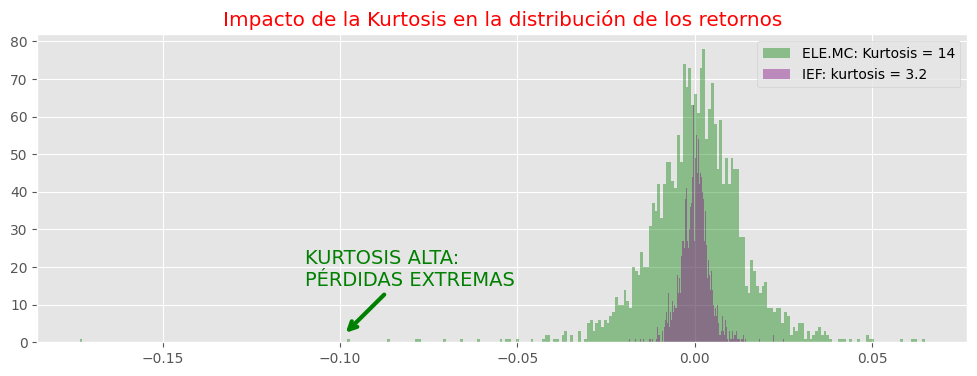

In [75]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.hist(ret_close_df['ELE.MC'], bins=300, color='green', alpha=0.4, label='ELE.MC: Kurtosis = 14')
#plt.hist(ret_close_df_corr['ORCL'], bins=300, color='green', alpha=0.4, label='ORCL')
plt.hist(ret_close_df['IEF'], bins=300, color='purple', alpha=0.4, label='IEF: kurtosis = 3.2')

# Dibuja una flecha utilizando annotate
ax.annotate('KURTOSIS ALTA:\nPÉRDIDAS EXTREMAS', xy=(-0.099, 2), xytext=(-0.11, 15),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

plt.title('Impacto de la Kurtosis en la distribución de los retornos')
plt.legend()
plt.show()  

## 1.5 Distribución t-Student para los retornos

La distribución t-Student es otra distribución de probabilidad que se usa para modelar la distribución de los retornos de los activos. Sus características son:

* Tiene forma de campana simétrica, como la distribución normal.

* Tiene **colas más pesadas** que la distribución normal, es decir, hay más probabilidad de que ocurran eventos extremos.

* Tiene un parámetro adicional llamado grados de libertad. Cuantos más grados de libertad, más se parece a una distribución normal.


Los grados de libertad en una distribución t de Student son un concepto crucial que influye en la forma de la distribución. Generalmente se refieren al número de valores en un cálculo que son libres de variar. 
 
La **distribución t de Student** es utilizada, por ejemplo, para estimar la media de una población cuando el tamaño de la muestra es pequeño y/o la desviación estándar de la población no es conocida. Es una distribución más ancha y más plana que la distribución normal, lo que compensa la incertidumbre adicional que surge al trabajar con muestras pequeñas.
 
**Cómo Afectan los Grados de Libertad**: 

- **Muestras Pequeñas**: Cuando trabajamos con muestras pequeñas, hay más incertidumbre en la estimación de la media poblacional. Con menos datos, hay más variabilidad en las estimaciones que podríamos hacer. Cuantos menos datos tengamos (es decir, cuantos menos grados de libertad), más ancha y más plana será la distribución t, reflejando esta mayor incertidumbre.
- **Muestras Grandes**: A medida que el tamaño de la muestra aumenta (y con él, los grados de libertad), la distribución t comienza a parecerse más a la distribución normal. Esto se debe a que con más datos, la estimación de la media se vuelve más precisa y hay menos variabilidad.

Veamos cómo se comportan los retornos de un activo con una distribución t-Student variando los grados de libertad:

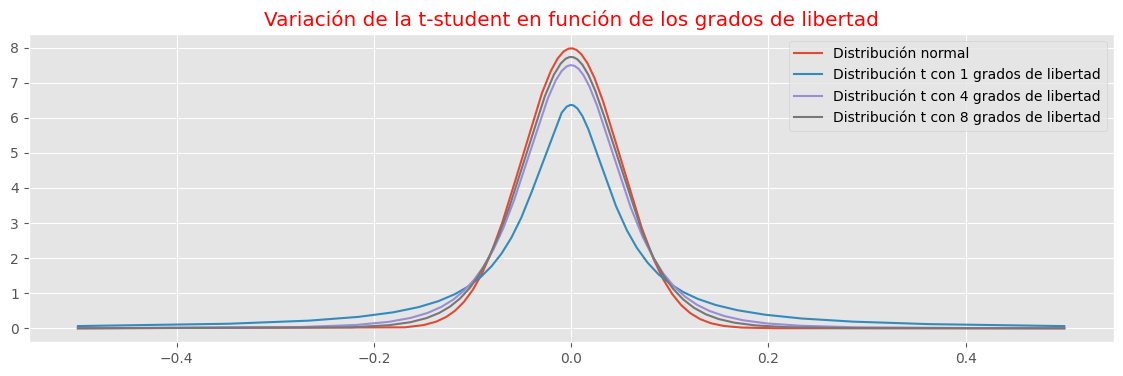

In [76]:
mu_btc = 0.0
sigma_btc = 0.05

xmin = -0.5
xmax = 0.5
x = np.linspace(xmin, xmax, 1000)
n_pdf = stats.norm.pdf(x, mu_btc, sigma_btc)

plt.figure(figsize=(14, 4))

plt.plot(x, n_pdf, label='Distribución normal')

for libertad_grad in [1, 4, 8]:
    t_params = (libertad_grad, mu_btc, sigma_btc) # parámetros de la distribución t-student
    t_pdf = stats.t.pdf(x, *t_params)

    # Duplicar el eje Y para el segundo gráfico
    plt.plot(x, t_pdf, label=f'Distribución t con {libertad_grad} grados de libertad')
    
plt.title('Variación de la t-student en función de los grados de libertad')
plt.legend()
plt.show()

## 1.6 Conclusiones

1- Hemos aprendido a estimar rentabilidades de un activo, que serán las que utilizaremos para su análisis descriptivo en lugar de los precios.


2- Hemos supuesto que las rentabilidades se comportan como una distribución Normal tipificada por su media y varianza.


3- La media es una medida de lo que esperamos obtener de rentabilidad y la desviación típica es una aproximación al riesgo que asumimos.


4- Se ha comprobado que en realidad, las funciones de distribución de los retornos de los activos no se comportan exactamente igual a una Normal. Generalmente tenemos colas pesadas con incidencias significativas en el resultado de nuestras inversiones.


5- Hemos estimado el tercer y cuarto momento (asimetría y curtosis) para tratar de cuantificar la importancia de las colas pesadas de la distribución.


6- Hemos utilizado funciones de distribución alternativas a la Normal, como la t-student, para modelizar el comportamiento de la rentabilidad de un activo.